In [1]:
import numpy as np 
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

#Regular expressions
import re

#Text processing
from unicodedata import normalize
import nltk 
from nltk.corpus import stopwords

#Huggingface
from transformers import Trainer
from transformers import AutoTokenizer
from transformers import pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments

#Pytorch and progress bar
import torch
from torch import nn
from tqdm.auto import tqdm

#Performance metric
from sklearn.metrics import f1_score

from os.path import exists

### 1. Loading Datasets

#### Spanish datasets

Selected emotions:

    -Sadness
    -Fear
    -Angry
    -Not-relevant

In [2]:
df_SpanishTweets_COVIDRelated = pd.read_csv("spanish_tweets-covid19-merged-dataset-unbalanced.csv")

df_SpanishTweets_COVIDRelated.head()

,id,tweet,processed_tweet,emotion
0,0,"""\""desastre tras desastre ... #catalunya #espa...",desastre tras desastre,sad
1,1,"""\""No había ninguna duda... y la cubana!!! htt...",no haber ninguno duda cubana,not-relevant
2,2,"""\""En 1año los sanitarios hemos pasado de ser ...",año sanitario haber pasar ser aplaudir agradec...,sad
3,3,Hey Donald espero que no saltarse sus medicame...,esperar no saltar medicamento mostrar ser hech...,sad
4,4,los cuales circular dice que si tengo una emer...,circular decir si tener emergencia querer ir h...,fear


**5260 entries** without null values.

Emotions:
- sad 

- not-relevant

- fear

- happy

- angry

- surprise

In [3]:
df_SpanishTweets_COVIDRelated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5260 entries, 0 to 5259
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5260 non-null   int64 
 1   tweet            5260 non-null   object
 2   processed_tweet  5250 non-null   object
 3   emotion          5260 non-null   object
dtypes: int64(1), object(3)
memory usage: 164.5+ KB


In [4]:
df_SpanishTweets_COVIDRelated.emotion.value_counts()

angry           1396
sad             1231
happy           1016
fear             801
not-relevant     792
surprise          24
Name: emotion, dtype: int64

In [5]:
df_SpanishTweets_COVIDRelated.emotion.unique()

array(['sad', 'not-relevant', 'fear', 'happy', 'angry', 'surprise'],
      dtype=object)

#### Depresion related tweets

In [9]:
df_SpanishTweets_DepressionRelated = pd.read_csv("spanish_tweets_suggesting_signs_of_depression_v1.csv")

df_SpanishTweets_DepressionRelated.drop(columns=["CREATED_AT"], inplace=True)

df_SpanishTweets_DepressionRelated.rename(columns={"TWEET_TEXT": "tweet", "TWEET_ID_ANON": "id"}, inplace=True)

df_SpanishTweets_DepressionRelated['emotion'] = "depressed"

df_SpanishTweets_DepressionRelated.head()

,id,USER_ID_ANON,tweet,emotion
0,1,1,Deberían eliminar a las malas personas y a los...,depressed
1,2,1,Ya deja de intentar contarle tus problemas a a...,depressed
2,3,1,La tristeza es lo más fácil de ocultar de todo...,depressed
3,4,1,De las peores cosas de la depresión es que no ...,depressed
4,5,1,La soledad es lo único constante en mi vida. C...,depressed


In [10]:
df_SpanishTweets_DepressionRelated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1000 non-null   int64 
 1   USER_ID_ANON  1000 non-null   int64 
 2   tweet         1000 non-null   object
 3   emotion       1000 non-null   object
dtypes: int64(2), object(2)
memory usage: 31.4+ KB


#### Neutral tweets

In [11]:
df_spanishSentiment = pd.read_csv("spanish_sentiment.tsv", sep='\t', header=0)

df_spanishSentiment.rename(columns={"text": "tweet", "label": "emotion"}, inplace=True)

df_spanishSentiment = df_spanishSentiment[df_spanishSentiment["emotion"] == "neutral"]

df_spanishSentiment.head()

,id,tweet,emotion
0,432597809246633984,RT TUSERUSER : Claro que uno se enamora y tamb...,neutral
1,441875458700083200,TUSERUSER yo MUERO 😍 ya hermosísimo desde pequ...,neutral
2,434182694113509378,RT TUSERUSER : Coño falta que corten la luz,neutral
3,432506327277895683,"RT TUSERUSER : Internet , "" azúcar "" , "" mar ""...",neutral
4,479805220877107204,Cosculluela Dice : No Soy El Malo Del Reggaetó...,neutral


In [12]:
df_spanishSentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7042 entries, 0 to 7623
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7042 non-null   int64 
 1   tweet    7042 non-null   object
 2   emotion  7042 non-null   object
dtypes: int64(1), object(2)
memory usage: 220.1+ KB


#### Merge

In [3]:
merged_spanishMerged_exists = exists("./df_spanishMerged.csv")

selected_emotions_spanish = ['sad', 'fear', 'angry', 'neutral', 'depressed']

if not merged_spanishMerged_exists:      
    df_spanishMerged = pd.DataFrame(pd.concat([df_SpanishTweets_COVIDRelated, df_SpanishTweets_DepressionRelated, df_spanishSentiment], names=['tweet', 'emotion'], ignore_index=True))
    df_spanishMerged.drop(df_spanishMerged[df_spanishMerged['emotion'].isna()].index, inplace=True)
    df_spanishMerged.drop(df_spanishMerged[df_spanishMerged.emotion == "emotion"].index, inplace=True)
    
    df_spanishMerged.drop(columns=['id', 'processed_tweet', 'USER_ID_ANON'], inplace=True)
    df_spanishMerged = df_spanishMerged[df_spanishMerged['emotion'].isin(selected_emotions_spanish)]

    df_spanishMerged['emotion'].replace({'sad': 'sadness', 'angry': 'anger'}, inplace=True)

    df_spanishMerged.to_csv('df_spanishMerged.csv', sep='|', index=False)
else :
    df_spanishMerged = pd.read_csv('df_spanishMerged.csv', sep='|')

In [52]:
df_spanishMerged.head()

,tweet,emotion
0,"""\""desastre tras desastre ... #catalunya #espa...",sadness
2,"""\""En 1año los sanitarios hemos pasado de ser ...",sadness
3,Hey Donald espero que no saltarse sus medicame...,sadness
4,los cuales circular dice que si tengo una emer...,fear
5,por mi marido hasta que el coronavirus ha mata...,fear


In [53]:
df_spanishMerged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12535 entries, 0 to 15471
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    12535 non-null  object
 1   emotion  12535 non-null  object
dtypes: object(2)
memory usage: 293.8+ KB


In [54]:
df_spanishMerged.emotion.value_counts()

neutral      7042
anger        2025
sadness      1667
depressed    1000
fear          801
Name: emotion, dtype: int64

-----
#### English datasets

#### GoEmotions

Selected emotions:

    -Remorse
    -Dissapointment
    -Nervousness
    -Embarrassment
    -Grief
    -Fear
    -Disgust

In [3]:
selected_emotions_english = ['disappointment', 'remorse', 'nervousness', 'embarrassment', 'grief', 'fear', 'disgust']

df_merged_goEmotions = pd.read_csv('df_merged_goEmotions.csv', sep='|')

df_merged_goEmotions = df_merged_goEmotions[df_merged_goEmotions.emotion.isin(selected_emotions_english)]

df_merged_goEmotions.head()

,tweet,emotion
10,"I wanted to downvote this, but it's not your f...",disappointment
12,That is odd.,disappointment
28,So happy for [NAME]. So sad he's not here. Ima...,disgust
31,"Dark and funny, but not really nice guy. He ha...",disappointment
39,Na. Rediting my post. Sorry for the ignorance.,remorse


In [4]:
df_merged_goEmotions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17511 entries, 10 to 207794
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    17511 non-null  object
 1   emotion  17511 non-null  object
dtypes: object(2)
memory usage: 410.4+ KB


In [5]:
df_merged_goEmotions.emotion.value_counts()

disappointment    6769
disgust           3420
fear              2514
embarrassment     1720
remorse           1648
nervousness        946
grief              494
Name: emotion, dtype: int64

#### Suicidal


In [6]:
df_suicidal_tweets = pd.read_csv('suicidal_tweets_reddit_corpus_all copy.csv', sep='|')

df_suicidal_tweets = df_suicidal_tweets[df_suicidal_tweets.cls == ' Risk']

df_suicidal_tweets.head()

,text,cls
6,"For number one , It doesn't matter how you kil...",Risk
8,"I feel so tired, so stressed, so empty. I don'...",Risk
15,"Hello, do I bother you? I'm crying, nobody tal...",Risk
16,"I feel like I'm nothing, just a burden. """,Risk
31,"They""ll probably be very disappointed If the ...",Risk


In [7]:
df_suicidal_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 6 to 300
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    183 non-null    object
 1   cls     183 non-null    object
dtypes: object(2)
memory usage: 4.3+ KB


In [8]:
df_suicidal_tweets['emotion'] = 'suicidal'

df_suicidal_tweets.drop(columns=['cls'], inplace=True)

df_suicidal_tweets.rename(columns={"text": "tweet"}, inplace=True)

df_suicidal_tweets.to_csv('suicidal_tweets_selected.csv', sep='|', index=False)

df_suicidal_tweets.head()

,tweet,emotion
6,"For number one , It doesn't matter how you kil...",suicidal
8,"I feel so tired, so stressed, so empty. I don'...",suicidal
15,"Hello, do I bother you? I'm crying, nobody tal...",suicidal
16,"I feel like I'm nothing, just a burden. """,suicidal
31,"They""ll probably be very disappointed If the ...",suicidal


In [9]:
df_suicidal_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 6 to 300
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    183 non-null    object
 1   emotion  183 non-null    object
dtypes: object(2)
memory usage: 4.3+ KB


In [10]:
df_merged_goEmotions_suicidal = pd.DataFrame(pd.concat([df_merged_goEmotions, df_suicidal_tweets], names=['tweet', 'emotion'], ignore_index=True))

df_merged_goEmotions_suicidal.head()

,tweet,emotion
0,"I wanted to downvote this, but it's not your f...",disappointment
1,That is odd.,disappointment
2,So happy for [NAME]. So sad he's not here. Ima...,disgust
3,"Dark and funny, but not really nice guy. He ha...",disappointment
4,Na. Rediting my post. Sorry for the ignorance.,remorse


In [13]:
df_merged_goEmotions_suicidal.to_csv('final_merged_goEmotions.csv', sep='|', index=False)

In [11]:
df_merged_goEmotions_suicidal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17694 entries, 0 to 17693
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    17694 non-null  object
 1   emotion  17694 non-null  object
dtypes: object(2)
memory usage: 276.6+ KB


In [12]:
df_merged_goEmotions_suicidal.emotion.value_counts()

disappointment    6769
disgust           3420
fear              2514
embarrassment     1720
remorse           1648
nervousness        946
grief              494
suicidal           183
Name: emotion, dtype: int64

### Depressed, Hopeless, Lonely and Suicide tweets

    -Depressed
    -Hopeless
    -Lonely
    -Suicide

In [96]:
df_depressed_drive = pd.read_csv('depressed-drive-tweets.csv', sep=',')

df_hopeless_drive = pd.read_csv('hopeless-drive-tweets1.csv', sep=',')

df_lonely_drive = pd.read_csv('lonely-drive-tweets1.csv', sep=',')

df_suicide_drive = pd.read_csv('suicide-drive-tweets1.csv', sep=',')

In [97]:
df_depressed_drive = df_depressed_drive[['tweet']]
df_depressed_drive['emotion'] = 'depressed'

df_hopeless_drive = df_hopeless_drive[['tweet']]
df_hopeless_drive['emotion'] = 'hopeless'

df_lonely_drive = df_lonely_drive[['tweet']]
df_lonely_drive['emotion'] = 'lonely'

df_suicide_drive = df_suicide_drive[['tweet']]
df_suicide_drive['emotion'] = 'suicidal'

#### Depressed

In [98]:
df_depressed_drive.head()

,tweet,emotion
0,Listen!! IM SORRY!! With her elder spirits g...,depressed
1,Im so pissed and depressed at the same time,depressed
2,"I’m just a hot mess that’s stressed, depressed...",depressed
3,Chen's probably depressed too since she's no l...,depressed
4,"Do you like it when I shake it for ya, daddy? ...",depressed


In [99]:
df_depressed_drive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20932 entries, 0 to 20931
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    20932 non-null  object
 1   emotion  20932 non-null  object
dtypes: object(2)
memory usage: 327.2+ KB


In [100]:
depression_related_words = ['overwhelmed', 'exhausted','anxiety', 'anxious', 'tired', 'low', 'depression', 'depressed', 'discouraged', 'desperate', 'demotivated', 'insomnia', 'cry', 'nervous', 'worried', 'lonely', 'sad', 'empty']

df_depressed_drive = df_depressed_drive[df_depressed_drive['tweet'].apply(lambda x: (len(str(x)) >=100) and (len(str(x)) <= 280))]
df_depressed_drive = df_depressed_drive[df_depressed_drive['tweet'].apply(lambda x: True if any(i in x for i in depression_related_words) else False)]

df_depressed_drive.to_csv('depressed_drive_clean.csv', sep='|', index=False)


In [102]:
df_depressed_drive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 2 to 20927
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    4993 non-null   object
 1   emotion  4993 non-null   object
dtypes: object(2)
memory usage: 117.0+ KB


#### Hopeless

In [104]:
df_hopeless_drive.head()

,tweet,emotion
0,"Hopeless, crazed, and dispossessed, I walked o...",hopeless
1,KAP haberini beklerken serSERİn olmuştuk,hopeless
2,17-july-2019. 🦉💛.,hopeless
3,เป็นไรสาวน้อย,hopeless
4,انا قاعده اعيش اسعد ايام حياتي💛.,hopeless


In [105]:
df_hopeless_drive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    9021 non-null   object
 1   emotion  9021 non-null   object
dtypes: object(2)
memory usage: 141.1+ KB


In [106]:
df_hopeless_drive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    9021 non-null   object
 1   emotion  9021 non-null   object
dtypes: object(2)
memory usage: 141.1+ KB


In [107]:
lonelines_terms = ['alone', 'feeling', 'lonely', 'depression', 'pain', 'sadness', 'isolation', 'fear', 'killing', 'feelings', 'anxiety', 'happiness', 'cure',
'solitude', 'hurts', 'emptiness', 'crippling', 'anger', 'silence', 'fill', 'suffering', 'relationships', 'empty', 'darkness', 'boredom']

lonely_terms = ['feel', 'sad', 'feeling', 'alone', 'friends', 'sometimes', 'single', 'felt', 'bored', 'feels', 'nights', 'scared', 'depressed', 'af', 'cold',
'island', 'christmas', 'empty', 'hearts', 'loneliness', 'miserable', 'surrounded', 'horny', 'asf', 'desperate']

solitude = ['alone', 'enjoy', 'peace', 'silence', 'loneliness', 'fortress', 'quiet', 'hundred', 'lonely', 'enjoying', 'comfort', 'prefer', 'nature',
'isolation', 'comfortable', 'bliss', 'moments', 'sea', 'presence', 'peaceful', 'seek', 'embrace', 'darkness', 'gabriel', 'inner']

In [108]:
df_hopeless_drive = df_hopeless_drive[df_hopeless_drive['tweet'].apply(lambda x: (len(str(x)) >=50) and (len(str(x)) <= 280))]
df_hopeless_drive = df_hopeless_drive[df_hopeless_drive['tweet'].apply(lambda x: True if (any(i in x for i in lonelines_terms) or any(i in x for i in lonely_terms)  or any(i in x for i in solitude)) else False)]

df_hopeless_drive.to_csv('hopeless_drive_clean.csv', sep='|', index=False)

In [110]:
df_hopeless_drive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191 entries, 0 to 9019
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    1191 non-null   object
 1   emotion  1191 non-null   object
dtypes: object(2)
memory usage: 27.9+ KB


#### Lonely

In [111]:
df_lonely_drive.head()

,tweet,emotion
0,i dont know why but he looks so lonely in this...,lonely
1,Я после того как увидела их начала отращивать ...,lonely
2,Even follow you on all social networks,lonely
3,"#Nowplaying: Garmonsway, Gibbon and Harrington...",lonely
4,Laying in this hammock every Sunday alone is g...,lonely


In [112]:
df_lonely_drive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53772 entries, 0 to 53771
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    53772 non-null  object
 1   emotion  53772 non-null  object
dtypes: object(2)
memory usage: 840.3+ KB


In [113]:
df_lonely_drive = df_lonely_drive[df_lonely_drive['tweet'].apply(lambda x: (len(str(x)) >=50) and (len(str(x)) <= 280))]
df_lonely_drive = df_lonely_drive[df_lonely_drive['tweet'].apply(lambda x: True if (any(i in x for i in lonelines_terms) and any(i in x for i in lonely_terms)  and any(i in x for i in solitude)) else False)]

df_lonely_drive.to_csv('lonely_drive_clean.csv', sep='|', index=False)

In [114]:
df_lonely_drive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5102 entries, 4 to 53744
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    5102 non-null   object
 1   emotion  5102 non-null   object
dtypes: object(2)
memory usage: 119.6+ KB


#### Suicidal

In [115]:
df_suicide_drive.head()

,tweet,emotion
0,Suicide Thoughts ....,suicidal
1,If I wake up as a white person in my next life...,suicidal
2,I fixed my bio (Cant add a banner because Twit...,suicidal
3,Weaponizign Suicide disturbs me a lot Cardi B ...,suicidal
4,#sam harcelé par ses camarades de classe se #s...,suicidal


In [116]:
df_suicide_drive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25128 entries, 0 to 25127
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    25128 non-null  object
 1   emotion  25128 non-null  object
dtypes: object(2)
memory usage: 392.8+ KB


In [117]:
suicidal_terms_related = ['suicide', 'suicidal', 'suic', 'self-harm', 'self-injury', 'self harm', 'self injury', 'hang myself', 'hung myself', 'kill myself', 'kills myself', 'take my life',
 'take my life', 'takes my life', 'want to die', 'wanted to die', 'wants to die', 'want death', 'wants death', 'wanted death', 'to be dead']

In [118]:
df_suicide_drive = df_suicide_drive[df_suicide_drive['tweet'].apply(lambda x: (len(str(x)) >=100) and (len(str(x)) <= 280))]
df_suicide_drive = df_suicide_drive[df_suicide_drive['tweet'].apply(lambda x: True if any(i in x for i in suicidal_terms_related) else False)]

df_suicide_drive.to_csv('suicide_drive_clean.csv', sep='|', index=False)

In [119]:
df_suicide_drive.head()

,tweet,emotion
1,If I wake up as a white person in my next life...,suicidal
2,I fixed my bio (Cant add a banner because Twit...,suicidal
5,I feel like if you go to a rooftop day-party i...,suicidal
6,"Raping, beating, and abusing prisoners is an a...",suicidal
16,@MarijnJH hello sir I am trying to understand ...,suicidal


In [120]:
df_suicide_drive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6734 entries, 1 to 25120
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    6734 non-null   object
 1   emotion  6734 non-null   object
dtypes: object(2)
memory usage: 157.8+ KB


#### Merge

In [122]:
df_merged_drive = pd.DataFrame(pd.concat([df_depressed_drive, df_hopeless_drive, df_lonely_drive, df_suicide_drive], names=['tweet', 'emotion'], ignore_index=True))

df_merged_drive.head()

,tweet,emotion
0,"I’m just a hot mess that’s stressed, depressed...",depressed
1,I'm so bored of this shit again. I'm so happy ...,depressed
2,"I loved your old stuff but this, this just mak...",depressed
3,"y’all ever get depressed asf, because the one ...",depressed
4,Actually liau is a sign of maturity i think bu...,depressed


In [123]:
df_merged_drive.to_csv('final_merged_drive.csv', sep='|', index=False)

In [124]:
df_merged_drive.emotion.value_counts()

suicidal     6734
lonely       5102
depressed    4993
hopeless     1191
Name: emotion, dtype: int64

#### Merging drive & goEmotions datasets

In [125]:
df_emotions_drive = pd.read_csv('final_merged_drive.csv', sep='|')
df_emotions_goEmotions = pd.read_csv('final_merged_goEmotions.csv', sep='|')

In [126]:
df_merged_drive_goEmotions = pd.DataFrame(pd.concat([df_emotions_drive, df_emotions_goEmotions], names=['tweet', 'emotion'], ignore_index=True))


In [127]:
df_merged_drive_goEmotions.emotion.value_counts()

suicidal          6917
disappointment    6769
lonely            5102
depressed         4993
disgust           3420
fear              2514
embarrassment     1720
remorse           1648
hopeless          1191
nervousness        946
grief              494
Name: emotion, dtype: int64

In [128]:
df_merged_drive_goEmotions.to_csv('final_drive_goEmotions.csv', sep='|', index=False)

In [16]:
df_merged_drive_goEmotions = pd.read_csv('final_drive_goEmotions.csv', sep='|')

In [18]:
df_merged_drive_goEmotions.head()

,tweet,emotion
0,"I’m just a hot mess that’s stressed, depressed...",depressed
1,I'm so bored of this shit again. I'm so happy ...,depressed
2,"I loved your old stuff but this, this just mak...",depressed
3,"y’all ever get depressed asf, because the one ...",depressed
4,Actually liau is a sign of maturity i think bu...,depressed


In [17]:
df_merged_drive_goEmotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35714 entries, 0 to 35713
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    35714 non-null  object
 1   emotion  35714 non-null  object
dtypes: object(2)
memory usage: 558.2+ KB


In [135]:
df_merged_drive_goEmotions.tweet[0:15000].to_excel('final_drive_goEmotions0_15000.xlsx', index=False)
df_merged_drive_goEmotions.tweet[15000:35714].to_excel('final_drive_goEmotions15000_35714.xlsx', index=False)

In [10]:
df_merged_drive_goEmotions0 = pd.read_excel('final_drive_goEmotions0_15000_esp.xlsx')
df_merged_drive_goEmotions1 = pd.read_excel('final_drive_goEmotions15000_35714_esp.xlsx')

In [14]:
df_merged_drive_goEmotions_esp = pd.DataFrame(pd.concat([df_merged_drive_goEmotions0, df_merged_drive_goEmotions1], ignore_index=True))
df_merged_drive_goEmotions_esp.head()

,Pío
0,Solo soy un desastre caliente que está estres...
1,Estoy tan aburrido de esta mierda de nuevo. E...
2,"Me encantaban tus cosas viejas, pero esto, es..."
3,"alguna vez se deprimen, porque la única perso..."
4,"En realidad, liau es un signo de madurez, cre..."


In [19]:
df_merged_drive_goEmotions_esp['emotion'] = df_merged_drive_goEmotions.emotion

In [22]:
df_merged_drive_goEmotions_esp.emotion.value_counts()

suicidal          6917
disappointment    6769
lonely            5102
depressed         4993
disgust           3420
fear              2514
embarrassment     1720
remorse           1648
hopeless          1191
nervousness        946
grief              494
Name: emotion, dtype: int64

In [24]:
df_merged_drive_goEmotions_esp.rename(columns={"Pío": "tweet"}, inplace=True)


In [26]:
df_merged_drive_goEmotions_esp.to_csv('ESP_merged_drive_goEmotions.csv', sep='|', index=False)

Final merge

In [27]:
df_esp_final = pd.DataFrame(pd.concat([df_merged_drive_goEmotions_esp, df_spanishMerged], names=['tweet', 'emotion'], ignore_index=True))
df_esp_final.head()

,tweet,emotion
0,Solo soy un desastre caliente que está estres...,depressed
1,Estoy tan aburrido de esta mierda de nuevo. E...,depressed
2,"Me encantaban tus cosas viejas, pero esto, es...",depressed
3,"alguna vez se deprimen, porque la única perso...",depressed
4,"En realidad, liau es un signo de madurez, cre...",depressed


In [28]:
df_esp_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48249 entries, 0 to 48248
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    48249 non-null  object
 1   emotion  48249 non-null  object
dtypes: object(2)
memory usage: 754.0+ KB


In [18]:
df_esp_final.to_csv('ESP_FINAL_CORPUS.csv', sep='|', index=False)

-------

### FINE-TUNING

In [2]:
df_esp_final = pd.read_csv('ESP_FINAL_CORPUS.csv', sep='|')

In [8]:
df_esp_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40806 entries, 0 to 40805
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    40806 non-null  object
 1   emotion  40806 non-null  object
dtypes: object(2)
memory usage: 637.7+ KB


In [9]:
df_esp_final.emotion.value_counts()

neutral           6995
suicidal          6830
depressed         5949
lonely            5023
disappointment    4765
disgust           2289
fear              2235
anger             1388
sadness           1201
hopeless          1180
embarrassment     1094
remorse            956
nervousness        611
grief              290
Name: emotion, dtype: int64

In [10]:
df_esp_final.emotion = pd.Categorical(df_esp_final.emotion)
df_esp_final['label'] = df_esp_final.emotion.cat.codes

In [11]:
id2label = df_esp_final[['emotion', 'label']].drop_duplicates(keep='first').sort_values(by='label').reset_index(drop=True)['emotion'].to_dict()
id2label

{0: 'anger',
 1: 'depressed',
 2: 'disappointment',
 3: 'disgust',
 4: 'embarrassment',
 5: 'fear',
 6: 'grief',
 7: 'hopeless',
 8: 'lonely',
 9: 'nervousness',
 10: 'neutral',
 11: 'remorse',
 12: 'sadness',
 13: 'suicidal'}

In [12]:
label2id = {v:k for k,v in id2label.items()}
label2id

{'anger': 0,
 'depressed': 1,
 'disappointment': 2,
 'disgust': 3,
 'embarrassment': 4,
 'fear': 5,
 'grief': 6,
 'hopeless': 7,
 'lonely': 8,
 'nervousness': 9,
 'neutral': 10,
 'remorse': 11,
 'sadness': 12,
 'suicidal': 13}

In [8]:
df_esp_final.drop(df_esp_final[df_esp_final.tweet.isna() == True].index, inplace=True)
df_esp_final.drop(columns='emotion', inplace=True)

df_esp_final

,tweet,label
0,Solo soy un desastre caliente que está estres...,1
1,Estoy tan aburrido de esta mierda de nuevo. E...,1
2,"Me encantaban tus cosas viejas, pero esto, es...",1
3,"alguna vez se deprimen, porque la única perso...",1
4,"En realidad, liau es un signo de madurez, cre...",1
...,...,...
40801,La gente le dice burro a otro y ni sabe escrib...,10
40802,"¡Dios Mío ! Yo creo , adoro , espero y os amo...",10
40803,En fotos : El hombre con el peor trabajo del m...,10
40804,Los chorros llamando a la policía para que los...,10


In [16]:
train, validation, test = np.split(df_esp_final.sample(frac=1), [int(.6*len(df_esp_final)), int(.8*len(df_esp_final))])

In [17]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
validation.reset_index(drop=True, inplace=True)

In [18]:
train.to_csv('train.csv', sep='|', index=False)
validation.to_csv('validation.csv', sep='|', index=False)
test.to_csv('test.csv', sep='|', index=False)

In [9]:
#train = pd.read_csv('train.csv', sep='|')
#validation = pd.read_csv('validation.csv', sep='|')
#test = pd.read_csv('test.csv', sep='|')

train = train[train['tweet'].map(len) <= 280]
validation = validation[validation['tweet'].map(len) <= 280]
test = test[test['tweet'].map(len) <= 280]


In [10]:
train.label.value_counts()

10    4246
1     3032
13    2897
2     2883
8     2733
3     1362
5     1252
0      728
4      662
12     595
11     572
7      545
9      375
6      186
Name: label, dtype: int64

In [11]:
validation.label.value_counts()

10    1357
13    1031
1      999
2      949
8      947
3      462
5      425
4      222
0      212
12     201
11     193
7      177
9      125
6       56
Name: label, dtype: int64

In [12]:
test.label.value_counts()

10    1389
1     1048
13    1020
2      933
8      847
3      465
5      459
0      242
4      210
12     205
11     191
7      185
9      111
6       48
Name: label, dtype: int64

In [10]:
train_dataset = Dataset.from_pandas(train)
validation_dataset = Dataset.from_pandas(validation)

In [11]:
#'roberta-base'
#'PlanTL-GOB-ES/roberta-base-bne'
#'dccuchile/bert-base-spanish-wwm-uncased'
#'bertin-project/bertin-roberta-base-spanish'
#'pysentimiento/robertuito-base-uncased'
#'google/electra-base-discriminator'
#'mrm8488/electricidad-base-discriminator'
#'mrm8488/RuPERTa-base'

model_ckpt='pysentimiento/robertuito-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [12]:
def tokenize_tweets(tweet):
    return tokenizer(tweet['tweet'], truncation=True, max_length=64) 

In [13]:
train_dataset = train_dataset.map(tokenize_tweets, batched=True)
train_dataset

100%|██████████| 23/23 [00:00<00:00, 25.91ba/s]


Dataset({
    features: ['__index_level_0__', 'attention_mask', 'input_ids', 'label', 'tweet'],
    num_rows: 22068
})

In [14]:
validation_dataset = validation_dataset.map(tokenize_tweets, batched=True)
validation_dataset

100%|██████████| 8/8 [00:00<00:00, 29.99ba/s]


Dataset({
    features: ['__index_level_0__', 'attention_mask', 'input_ids', 'label', 'tweet'],
    num_rows: 7356
})

In [15]:
class_weights = (1 - (train['label'].value_counts().sort_index() /len(train))).values 
class_weights

class_weights = torch.from_numpy(class_weights).float().to("cuda")

tensor([0.9670, 0.8626, 0.8694, 0.9383, 0.9700, 0.9433, 0.9916, 0.9753, 0.8762,
        0.9830, 0.8076, 0.9741, 0.9730, 0.8687], device='cuda:0')

In [24]:
torch.cuda.is_available()

True

In [16]:
train_dataset = train_dataset.rename_column("label", "labels")
validation_dataset = validation_dataset.rename_column("label", "labels")

train_dataset = train_dataset.rename_column("tweet", "text")
validation_dataset = validation_dataset.rename_column("tweet", "text")

In [17]:
#Loss function
class WheightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = inputs.get("labels")
        loss_func = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_func(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [18]:
num_labels = len(id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at mrm8488/RuPERTa-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mrm8488/RuPERTa-base and are newly initialized

In [19]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    return {"f1": f1}

In [20]:
#Training Arguments
batch_size = 16
logging_steps = len(train_dataset)
output_dir = "finetuned-emotion"
training_args = TrainingArguments(output_dir=output_dir,
                                  num_train_epochs=2, 
                                  learning_rate=5e-5, 
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size, 
                                  weight_decay=0.01, 
                                  evaluation_strategy="epoch", 
                                  logging_steps=logging_steps, 
                                  fp16=True,
                                  )

In [21]:
trainer = WheightedLossTrainer(model=model,
                               args=training_args,
                               compute_metrics=compute_metrics,
                               train_dataset=train_dataset,
                               eval_dataset=validation_dataset,
                               tokenizer=tokenizer)

Using amp half precision backend


In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model(model_ckpt + '-save')
tokenizer.save_pretrained(model_ckpt + '-save')

--------
### UTILS

In [4]:
def predictEmotion(data, model):
    pipe = pipeline("text-classification", model=model)
    test = pd.read_csv(data, sep="|")
    test_dataset = Dataset.from_pandas(test)

    predictedLabel = []
    for prediction in tqdm(pipe(KeyDataset(test_dataset, "tweet"))):
        predictedLabel.append(label2id.get(prediction.get('label')))
        
    test['predicted_label'] = predictedLabel

    return test


In [26]:
def saveConfusionMatrix(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(10, 10))
    labels = list(label2id)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp = disp.plot(xticks_rotation=-45, ax=ax)
    plt.title(imgName,  fontsize=18, pad=20)    
    plt.savefig(imgName, bbox_inches='tight')

In [27]:
def saveClassificationReport(imgName, y_true, y_pred, labels):
    clf_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    clf_report = pd.DataFrame(clf_report).iloc[:-1, :].transpose()
    clf_report_macro = clf_report[14:]
    clf_report = clf_report[0:14].sort_values(by=['f1-score'], ascending=False)
    clf_report= pd.concat([clf_report, clf_report_macro])
    ax = sns.heatmap(clf_report, annot=True)
    ax.xaxis.tick_top() # x axis on top
    plt.title("classification_report_" + imgName,  fontsize=18, pad=20 )
    plt.savefig(imgName + '_clf', bbox_inches='tight')

    return clf_report


In [2]:
def printMacroF1(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average=None)
    i = 0
    for label in label2id:
        print(label, ": ", round(f1[i], 2))
        i+=1

---------

### Model results

In [29]:
imgName = 'RuPERTa-base'
data = 'test.csv'
modelSaved = 'mrm8488/RuPERTa-base-save'

loading configuration file mrm8488/RuPERTa-base-save\config.json
Model config RobertaConfig {
  "_name_or_path": "mrm8488/RuPERTa-base-save",
  "_num_labels": 2,
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "depressed",
    "2": "disappointment",
    "3": "disgust",
    "4": "embarrassment",
    "5": "fear",
    "6": "grief",
    "7": "hopeless",
    "8": "lonely",
    "9": "nervousness",
    "10": "neutral",
    "11": "remorse",
    "12": "sadness",
    "13": "suicidal"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "depressed": 1,
    "disappointment": 2,
    "disgust": 3,
    "embarrassment": 4,
    "fear": 5,
    "grief": 6,
    "hopeless": 7,
    "lonely": 8,
    "nervousness": 9,
   

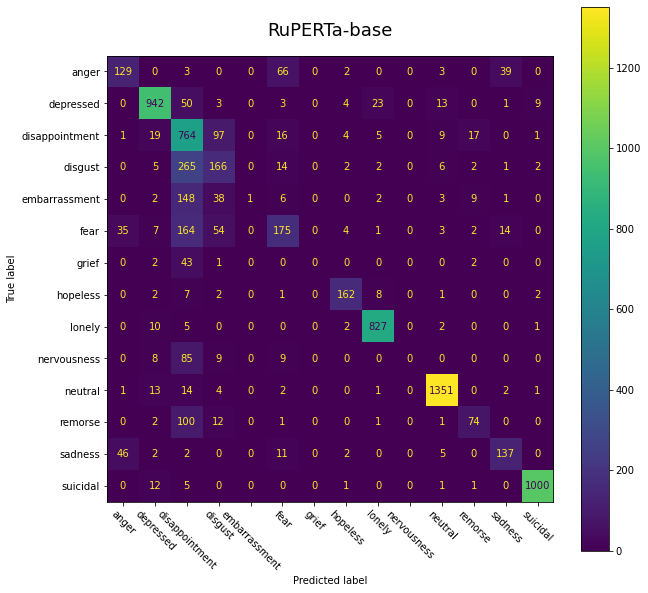

In [30]:
test = predictEmotion(data, modelSaved )

y_true = test['label']
y_pred = test['predicted_label']
labels = list(label2id)

saveConfusionMatrix(y_true, y_pred)

c:\Users\Alejandro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Alejandro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Alejandro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score
suicidal,0.984252,0.980392,0.982318
neutral,0.966381,0.972642,0.969501
lonely,0.950575,0.976387,0.963308
depressed,0.918129,0.898855,0.908390
hopeless,0.885246,0.875676,0.880435
sadness,0.702564,0.668293,0.685000
disappointment,0.461631,0.818864,0.590417
anger,0.608491,0.533058,0.568282
remorse,0.691589,0.387435,0.496644
fear,0.575658,0.381264,0.458716


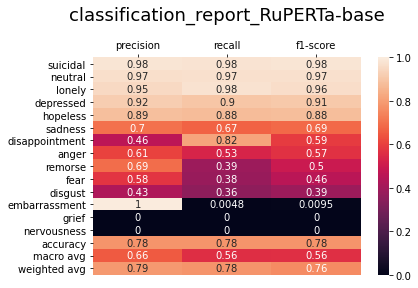

In [31]:
saveClassificationReport(imgName, y_true, y_pred, labels)

In [ ]:
#printMacroF1(y_true, y_pred)
#print("\nMacro:", f1_score(y_true, y_pred, average='macro'))


--------------------

### Text cleaning

In [44]:
trans_tab = dict.fromkeys(map(ord, u'\u0301\u0308'), None)

def clean_text(text): #without removing hastags #word
    text = normalize('NFKC', normalize('NFKD', text).translate(trans_tab))
    text = re.sub("RT TUSERUSER :", " ", text) # remove newline
    text = re.sub("TUSERUSER", " ", text) # remove newline
    text = re.sub("\n'", " ", text) # remove newline
    text = re.sub("\'", "", text) # remove backslash-apostrophe
    text = re.sub("[^a-zA-ZÑñ]"," ",text) # remove non alphabetic
    text = re.sub(r"(@\w+)|#|&|!", " ", text) #remo @peson
    text = re.sub(r"http\S+.*", " ", text) #renove links
    text = ' '.join(text.split()) # remove whitespaces 
    text = text.lower()  # to lowercase 

    return text


--------------

### Fine-tuning cleaned dataset

In [ ]:
train_clean = pd.read_csv('train_clean.csv', sep='|')
validation_clean = pd.read_csv('validation_clean.csv', sep='|')
test_clean = pd.read_csv('test_clean.csv', sep='|')

train_clean['tweet'] = train_clean['tweet'].astype(str)
validation_clean['tweet'] = validation_clean['tweet'].astype(str)
test_clean['tweet'] = test_clean['tweet'].astype(str)

train_dataset_clean = Dataset.from_pandas(train_clean)
validation_dataset_clean = Dataset.from_pandas(validation_clean)
test_dataset_clean = Dataset.from_pandas(test_clean)

df_esp_final_clean = pd.read_csv('ESP_FINAL_CORPUS_CLEAN.csv', sep='|')

df_esp_final_clean.emotion.value_counts()
df_esp_final_clean.emotion = pd.Categorical(df_esp_final_clean.emotion)
df_esp_final_clean['label'] = df_esp_final_clean.emotion.cat.codes

id2label_clean = df_esp_final_clean[['emotion', 'label']].drop_duplicates(keep='first').sort_values(by='label').reset_index(drop=True)['emotion'].to_dict()
label2id_clean = {v:k for k,v in id2label_clean.items()}

train_dataset_clean = train_dataset_clean.map(tokenize_tweets, batched=True)
validation_dataset_clean = validation_dataset_clean.map(tokenize_tweets, batched=True)
test_dataset_clean = test_dataset_clean.map(tokenize_tweets, batched=True)


class_weights_clean = (1 - (train_clean['label'].value_counts().sort_index() /len(train_clean))).values 
class_weights_clean

class_weights_clean = torch.from_numpy(class_weights_clean).float().to("cuda")

torch.cuda.is_available()

train_dataset_clean = train_dataset_clean.rename_column("label", "labels")
validation_dataset_clean = validation_dataset_clean.rename_column("label", "labels")
test_dataset_clean = test_dataset_clean.rename_column("label", "labels")

train_dataset_clean = train_dataset_clean.rename_column("tweet", "text")
validation_dataset_clean = validation_dataset_clean.rename_column("tweet", "text")
test_dataset_clean = test_dataset_clean.rename_column("tweet", "text")


batch_size = 16
logging_steps = len(train_dataset_clean)
output_dir_clean = "finetuned-emotion-clean"
training_args = TrainingArguments(output_dir=output_dir_clean,
                                  num_train_epochs=2, 
                                  learning_rate=5e-5, 
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size, 
                                  weight_decay=0.01, 
                                  evaluation_strategy="epoch", 
                                  logging_steps=logging_steps, 
                                  fp16=True
                                  )
                         
trainer = WheightedLossTrainer(model=model,
                               args=training_args,
                               compute_metrics=compute_metrics,
                               train_dataset=train_dataset_clean,
                               eval_dataset=validation_dataset_clean,
                               tokenizer=tokenizer)
trainer.train()

trainer.save_model(model_ckpt + '-save-clean')
tokenizer.save_pretrained(model_ckpt + '-save-clean')

trainer.evaluate()

In [35]:
imgName = 'RuPERTa-base-clean'
data = 'test_clean.csv'
modelSaved = 'mrm8488/RuPERTa-base-save-clean'

loading configuration file mrm8488/RuPERTa-base-save-clean\config.json
Model config RobertaConfig {
  "_name_or_path": "mrm8488/RuPERTa-base-save-clean",
  "_num_labels": 2,
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "depressed",
    "2": "disappointment",
    "3": "disgust",
    "4": "embarrassment",
    "5": "fear",
    "6": "grief",
    "7": "hopeless",
    "8": "lonely",
    "9": "nervousness",
    "10": "neutral",
    "11": "remorse",
    "12": "sadness",
    "13": "suicidal"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "depressed": 1,
    "disappointment": 2,
    "disgust": 3,
    "embarrassment": 4,
    "fear": 5,
    "grief": 6,
    "hopeless": 7,
    "lonely": 8,
    "nervousn

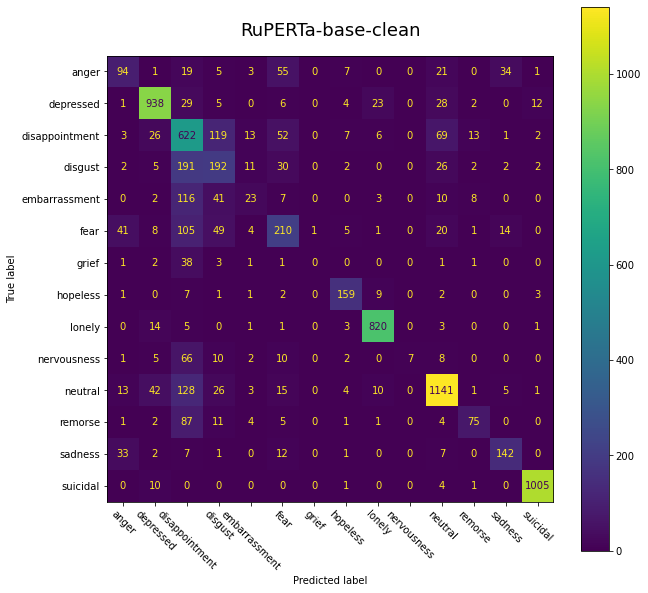

In [36]:
test = predictEmotion(data, modelSaved)

y_true = test['label']
y_pred = test['predicted_label']
labels = list(label2id)

saveConfusionMatrix(y_true, y_pred)

,precision,recall,f1-score
suicidal,0.978578,0.984329,0.981445
lonely,0.939290,0.966981,0.952934
depressed,0.887417,0.895038,0.891211
neutral,0.848958,0.821454,0.834980
hopeless,0.811224,0.859459,0.834646
sadness,0.717172,0.692683,0.704715
disappointment,0.438028,0.666667,0.528687
remorse,0.721154,0.392670,0.508475
fear,0.517241,0.457516,0.485549
anger,0.492147,0.391667,0.436195


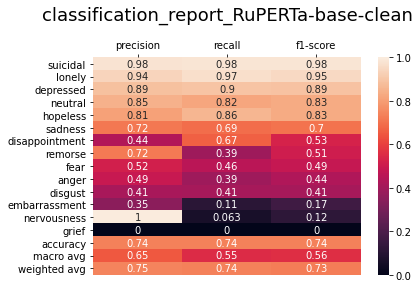

In [37]:
saveClassificationReport(imgName, y_true, y_pred, labels)

----------------

### Words frequency


In [115]:
def freq_words(x, plt): 
  all_words = ' '.join([text for text in x]) #join all words and split
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) #freq
  
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  words_df.sort_values(by='count', ascending=False, inplace=True)
  
  if (plt):
    fig = plt.figure(figsize=(12,8))
    sns.barplot(data= words_df[0:20], x='count', y='word')

  return words_df[0:20]

### Removing stopwords


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alejandro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [116]:
df_esp_final_clean = pd.read_csv('ESP_FINAL_CORPUS_CLEAN.csv', sep='|')

In [121]:
disappointment_tweets = df_esp_final_clean.tweet[df_esp_final_clean.emotion == 'disappointment']
disgust_tweets = df_esp_final_clean.tweet[df_esp_final_clean.emotion == 'disgust']
embarrassment_tweets = df_esp_final_clean.tweet[df_esp_final_clean.emotion == 'embarrassment']
fear_tweets = df_esp_final_clean.tweet[df_esp_final_clean.emotion == 'fear']
nervousness_tweets = df_esp_final_clean.tweet[df_esp_final_clean.emotion == 'nervousness']
hopeless_tweets = df_esp_final_clean.tweet[df_esp_final_clean.emotion == 'hopeless']


In [122]:
dissappointment_no_stopwords = disappointment_tweets.apply(lambda x: remove_stopwords(x)) #remove stopwords
disgust_no_stopwords = disgust_tweets.apply(lambda x: remove_stopwords(x)) 
embarrassment_no_stopwords = embarrassment_tweets.apply(lambda x: remove_stopwords(x)) 
fear_no_stopwords = fear_tweets.apply(lambda x: remove_stopwords(x))
nervousness_stopwords = nervousness_tweets.apply(lambda x: remove_stopwords(x))
hopeless_no_stopwords = hopeless_tweets.apply(lambda x: remove_stopwords(x))


In [123]:
disappointment_freq = freq_words(dissappointment_no_stopwords, False) #most freqent words without stopwords
disgust_freq = freq_words(disgust_no_stopwords, False) 
embarrassment_freq = freq_words(embarrassment_no_stopwords, False) 
fear_freq = freq_words(fear_no_stopwords, False) 
nervousness_freq = freq_words(nervousness_stopwords, False) 
hopeless_freq = freq_words(hopeless_no_stopwords, False) 


In [127]:
freq_merge0 = pd.concat([disappointment_freq, disgust_freq, embarrassment_freq, fear_freq], keys=['disappointment', 'disgust', 'embarrassment', 'fear']).reset_index().rename(columns={'level_0': 'Clase'})


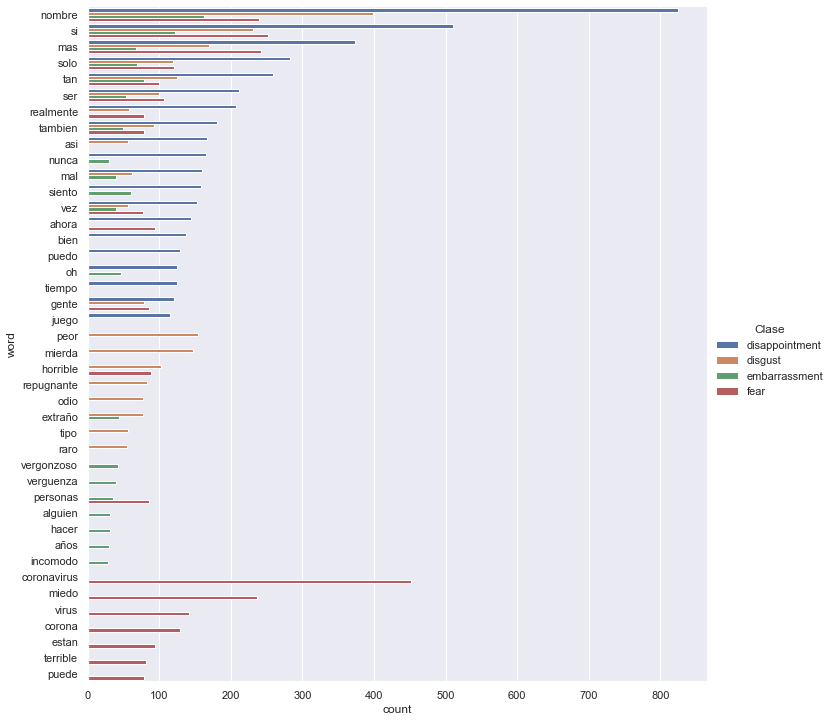

In [131]:
sns.catplot(x='count', y='word', hue='Clase', kind='bar', data=freq_merge0, height=10, aspect=10/10)

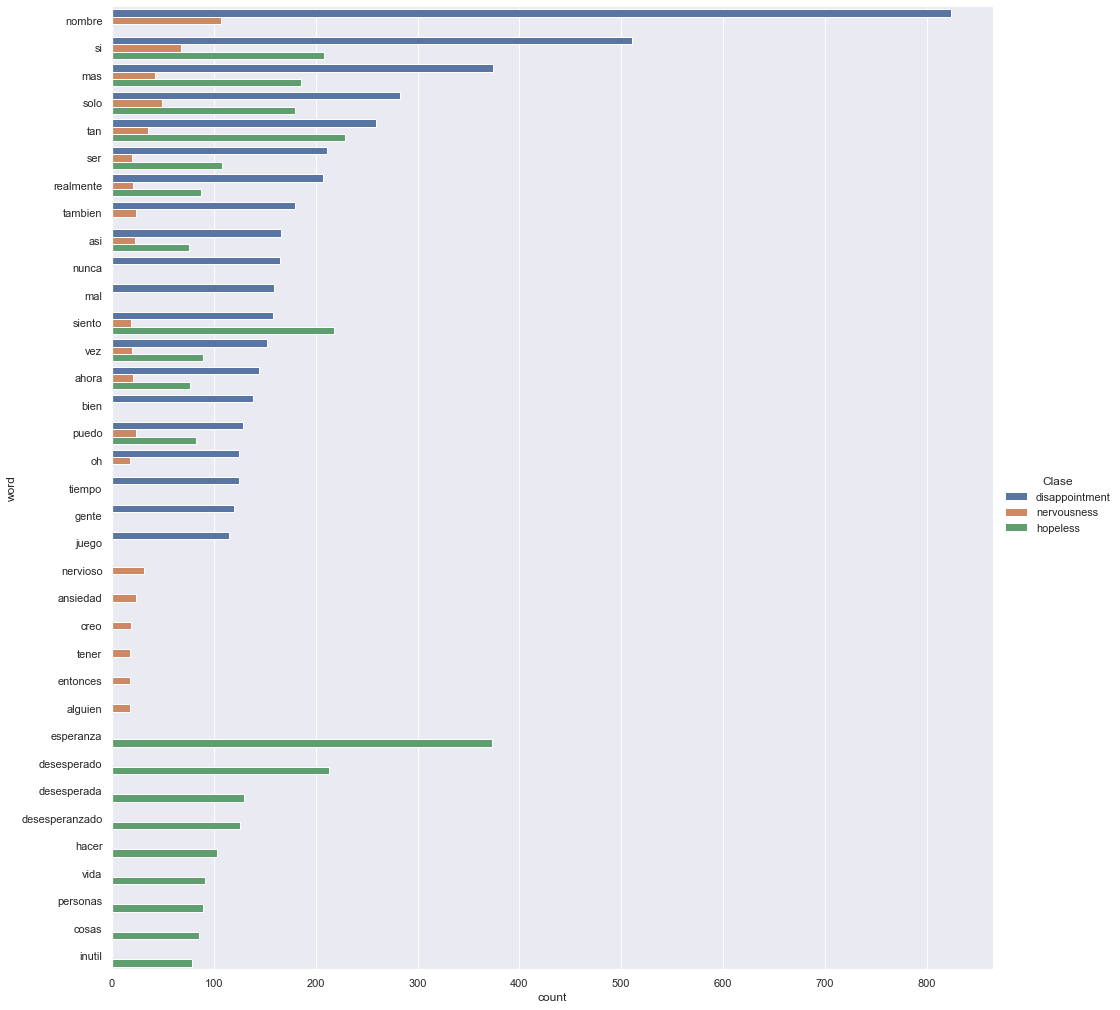

In [132]:
freq_merge1 = pd.concat([disappointment_freq, nervousness_freq, hopeless_freq], keys=['disappointment', 'nervousness', 'hopeless',]).reset_index().rename(columns={'level_0': 'Clase'})

sns.catplot(x='count', y='word', hue='Clase', kind='bar', data=freq_merge1, height=14, aspect=14/14)